# 3. Encoder-decoder with dropout

In this notebook we will explore and develop the the encoder-decoder part of the model (§3.2.1 in the paper). 

This encoder-decoder network is part of a 'pre-training' phase which aims to extract useful predictive time series features in an unsupervised manner that can then be fed into a prediction network for during the training phase.

For a univariate time series sample $\{x_1, ..., x_T, x_{T+1}, ..., x_{T+F}\}$, $F < T$,  the encoder reads in $\{x_1, ..., x_T\}$ to produce a fixed-size embedding. This embedding is then concatenated with the time series values $\{x_{T-F}, ..., x_{T}\}$ which forms the input into the decoder. The decoder takes this concatenation and tries to construct the series $\{x_{T+1}, ..., x_{T+F}\}$

The encoder and decoder consist of LSTM layers.

## 3.1 Load data

The `src/data.py` module now includes the data preprocessing code from notebook 1


In [1]:
# allows for import from `src` directory
import sys 
sys.path.append('../')

from src import data

n_input_steps  = 48
n_output_steps = 12

# run the preprocessing pipeline
df, split_dfs, samples = data.pipeline(n_input_steps, n_output_steps)

Data already downloaded
43910 train rows from 2012-10-02 09:00:00 to 2017-10-05 23:00:00
4320 valid rows from 2017-10-05 23:00:00 to 2018-04-03 23:00:00
4321 test rows from 2018-04-03 23:00:00 to 2018-09-30 23:00:00
16625 samples of 48 input steps and 12 output steps in train
3534 samples of 48 input steps and 12 output steps in valid
4020 samples of 48 input steps and 12 output steps in test


## 3.2 Prototype the encoder-decoder model with dropout

In [2]:
import torch
import torch.nn as nn

from models import variational_dropout as vd

class VDEncoder(nn.Module):
    def __init__(self, in_features, out_features, p):
        super(VDEncoder, self).__init__()
        self.model = nn.ModuleDict({
            'lstm1': vd.LSTM(in_features, 32,dropouto=p),
            'lstm2': vd.LSTM(32, 8, dropouto=p),
            'lstm3': vd.LSTM(8, out_features, dropouto=p)
        })
    
    def forward(self, x):
        out, _ = self.model['lstm1'](x)
        out, _ = self.model['lstm2'](out)
        out, _ = self.model['lstm3'](out)

        return out


class VDDecoder(nn.Module):
    def __init__(self, p):
        super(VDDecoder, self).__init__()
        self.model = nn.ModuleDict({
            'lstm1': vd.LSTM(1, 2, dropouto=p),
            'lstm2': vd.LSTM(2, 2, dropouto=p),
            'lstm3': vd.LSTM(2, 1, dropouto=p)
        })
    
    def forward(self, x):
        out, _ = self.model['lstm1'](x)
        out, _ = self.model['lstm2'](out)
        out, _ = self.model['lstm3'](out)

        return out


class VDEncoderDecoder(nn.Module):
    def __init__(self, in_features, output_steps, p):
        super(VDEncoderDecoder, self).__init__()
        self.enc_in_features = in_features
        self.output_steps = output_steps # f in the paper
        self.enc_out_features = 1
        self.traffic_col = 4
        self.p = p
        
        self.model = nn.ModuleDict({
            'encoder': VDEncoder(self.enc_in_features, self.enc_out_features, self.p),
            'decoder': VDDecoder(self.p),
            'fc1': nn.Linear(60, 32),
            'fc2': nn.Linear(32, self.output_steps)
        })

    def forward(self, x):
        out = self.model['encoder'](x)
        
        x_auxiliary = x[:,-self.output_steps:,[self.traffic_col]]
        decoder_input = torch.cat([out, x_auxiliary], dim=1)

        out = self.model['decoder'](decoder_input)
        out = self.model['fc1'](out.view(-1, 60))
        out = self.model['fc2'](out)

        return out

## 3.3 Train the encoder decoder model

In [3]:
from tqdm import tqdm
from src import utils

datasets = data.get_datasets(samples, n_input_steps)

params = {
    'num_epochs': 50,
    'batch_size': 128,
    'learning_rate': 1e-4,
    'p_dropout': 0.25,
    'encoder_in_features': datasets['train'].X.shape[-1]
}

dataloaders = data.get_dataloaders(datasets, params['batch_size'])
device = utils.get_device()
model = VDEncoderDecoder(in_features=params['encoder_in_features'], 
                         output_steps=n_output_steps, p=params['p_dropout'])

model, losses = utils.train(device, model, dataloaders['train'], params, use_tqdm=True)

Epoch=49 | [16625|16625]	loss=0.8345: 100%|██████████| 50/50 [25:06<00:00, 30.13s/it]


## 3.4 Training loss after 50 epochs

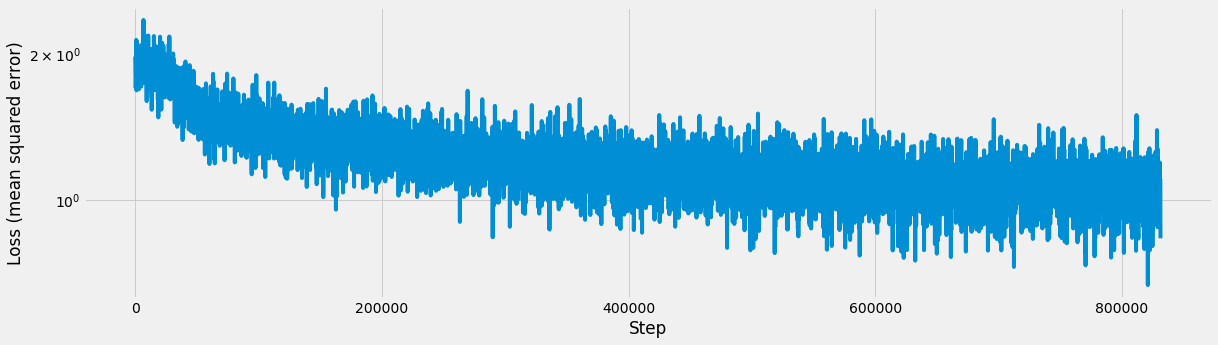

In [4]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

fig, axs = plt.subplots(1,1, figsize=(18,5))
_   = axs.plot(*np.array(losses)[:].T,label='training loss')
_   = axs.set_ylabel('Loss (mean squared error)')
_   = axs.set_xlabel('Step')
_   = axs.set_yscale('log')

## 3.5 Plot some predictions on validation data after 50 epochs 

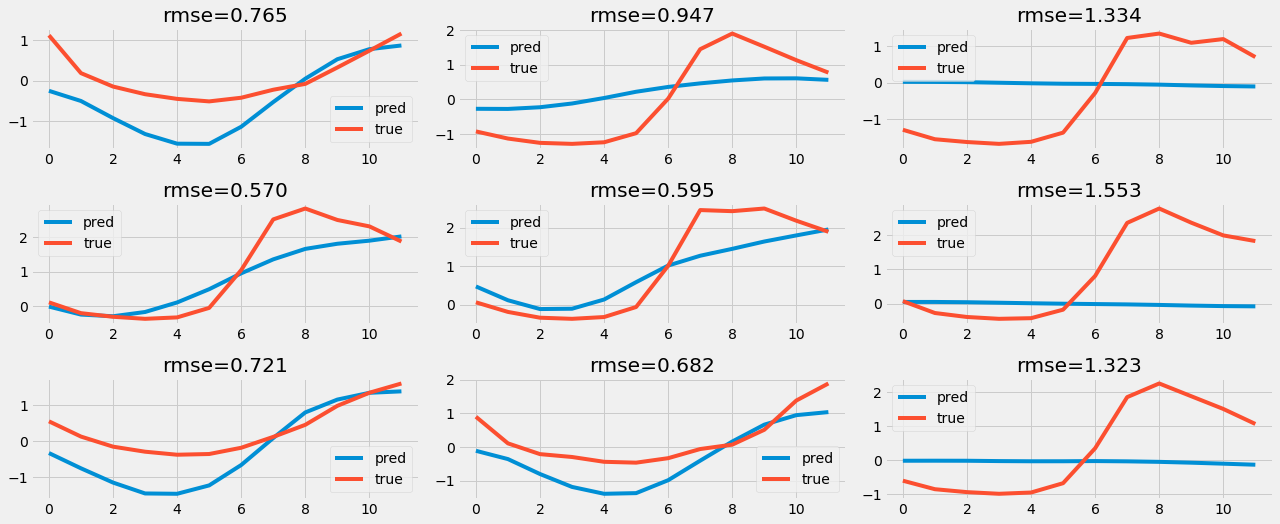

In [5]:
for x,y in dataloaders['valid']:
    break
y_pred = model(x).detach().numpy()[::24]
y = y[::24]

n_rows, n_cols = 3,3
fig,axs = plt.subplots(n_rows, n_cols,figsize=(6*n_cols, 2.5*n_rows))
for r in range(n_rows):
    for c in range(n_cols):
        i = r*n_rows+c
        axs[r][c].plot(y_pred[i],label='pred')
        axs[r][c].plot(y[i,:].numpy(),label='true')
        axs[r][c].legend()
        rmse = np.sqrt(np.mean((y_pred[i] - y[i,:].numpy())**2))
        axs[r][c].set_title('rmse={0:.3f}'.format(rmse))
plt.tight_layout()